In [13]:
!pip3 install matplotlib numpy sympy

import numpy as np
import matplotlib.pyplot as plt
import sympy as s

In [14]:
m = 0.02
w = np.pi
r = 0.5
g = 9.81


In [15]:
c2 = 0.2 / w + g / (4 * w**2)
c1 = -(0.2 / w + g / (4 * w**2))

dx = (
    lambda t: -g * np.cos(w * t) / (2 * w)
    - w * c1 * np.e ** (-w * t)
    + w * c2 * np.e ** (w * t)
)
x = (
    lambda t: -g * np.cos(np.pi / 2 - w * t) / (2 * w**2)
    + c1 * np.e ** (-w * t)
    + c2 * np.e ** (w * t)
)


In [16]:
# find the time when the x(t) = r using scipy
from scipy.optimize import fsolve

t = fsolve(lambda t: x(t) - r, 0)
t_finish = t[0]

t_finish, t

(0.388842472451747, array([0.38884247]))

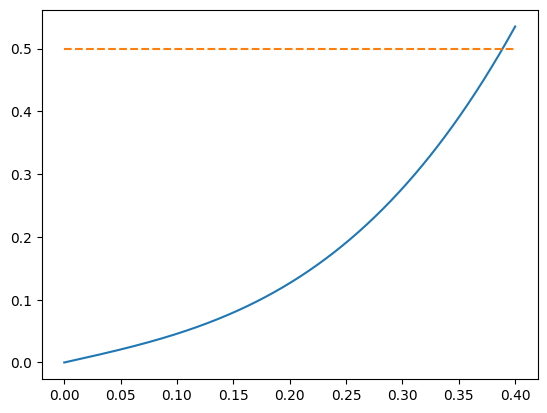

In [17]:
# plot x(t)

t = np.linspace(0, 0.4, 1000)
plt.plot(t, x(t))
plt.plot(t, np.ones_like(t) * r, "--")


In [74]:
from dataclasses import dataclass


@dataclass
class Trace:
    t: float

    @property
    def x(self):
        """x in tube frame"""
        return np.array([x(self.t), 0, 0])

    @property
    def xglobal(self):
        return np.dot(self.from_tube, self.x)

    @property
    def phi(self):
        return self.t * -w

    @property
    def from_tube(self):
        """returns transformation from tube frame to world frame"""
        return np.array(
            [
                [np.cos(self.phi), -np.sin(self.phi), 0],
                [np.sin(self.phi), np.cos(self.phi), 0],
                [0, 0, 1],
            ]
        )

    @property
    def mg(self):
        return np.array([0, -m * g, 0])

    @property
    def acc_cor(self):
        return 2 * np.cross(
            np.array([0, 0, -w]),
            np.dot(self.from_tube, np.array([dx(self.t), 0, 0])),
        )

    @property
    def acc_tr(self):
        return np.cross(
            np.array([0, 0, -w]),
            np.cross(
                np.array([0, 0, -w]),
                self.xglobal,
            ),
        )

    @property
    def reaction(self):
        norm = np.linalg.norm(self.mg) * np.cos(self.phi) - m * np.linalg.norm(
            self.acc_cor
        )
        direction = np.cross(np.array([0, 0, 1]), self.xglobal)

        return norm * direction / np.linalg.norm(direction)

        #  np.linalg.norm(t.mg) * np.cos(t.phi) - m * np.linalg.norm(t.acc_cor) for t in traces
        # find projection of mg on acc_cor
        mgsin = (
            np.dot(self.mg, self.acc_cor)
            / np.linalg.norm(self.acc_cor)
            * self.acc_cor
            / np.linalg.norm(self.acc_cor)
        )

        return -self.acc_cor - mgsin

    def animate(self, actors):
        actors["M"].center = (np.dot(self.from_tube, self.x))[:2]

        dangle = 0.03
        actors["tube1"].set_data(
            [r * np.cos(self.phi + dangle), r * np.cos(self.phi + np.pi - dangle)],
            [r * np.sin(self.phi + dangle), r * np.sin(self.phi + np.pi - dangle)],
        )
        actors["tube2"].set_data(
            [r * np.cos(self.phi - dangle), r * np.cos(self.phi - np.pi + dangle)],
            [r * np.sin(self.phi - dangle), r * np.sin(self.phi - np.pi + dangle)],
        )
        actors["mg"].set_data(
            x=self.xglobal[0],
            y=self.xglobal[1],
            dx=self.mg[0],
            dy=self.mg[1],
        )
        actors["coriolis"].set_data(
            x=self.xglobal[0],
            y=self.xglobal[1],
            dx=self.acc_cor[0] * -m,
            dy=self.acc_cor[1] * -m,
        )
        actors["reaction"].set_data(
            x=self.xglobal[0],
            y=self.xglobal[1],
            dx=self.reaction[0],
            dy=self.reaction[1],
        )
        actors["transport"].set_data(
            x=self.xglobal[0],
            y=self.xglobal[1],
            dx=self.acc_tr[0] * -m,
            dy=self.acc_tr[1] * -m,
        )


In [75]:
traces = [Trace(t) for t in np.linspace(0, t_finish, 100)]


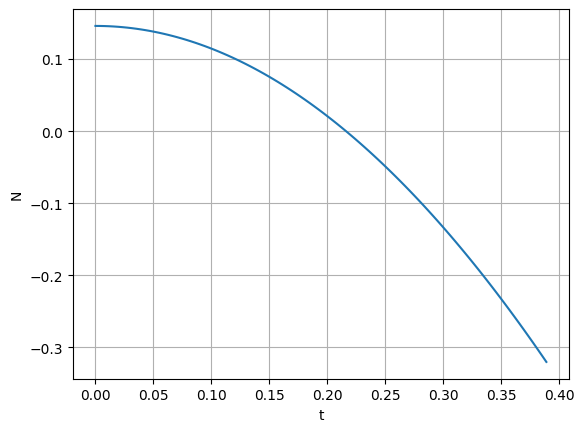

In [88]:
N = [
    (np.sign(np.dot(t.reaction, np.array([0, 1, 0]))) if i != 0 else 1)
    * np.linalg.norm(t.reaction)
    for i, t in enumerate(traces)
]
times = [t.t for t in traces]

plt.xlabel("t")
plt.ylabel("N")
plt.grid()
plt.plot(times, N, label="N")

plt.savefig("task2n.png")


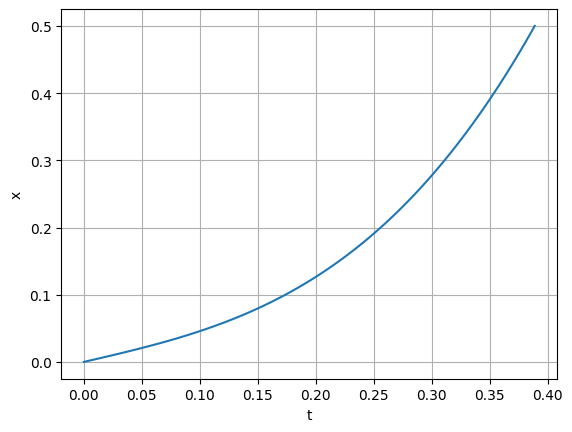

In [77]:
xvals = [t.x[0] for t in traces]
times = [t.t for t in traces]

plt.xlabel("t")
plt.ylabel("x")
plt.grid()
plt.plot(times, xvals, label="x")

plt.savefig("task2x.png")

0
0
10
20
30
40
50
60
70
80
90
0


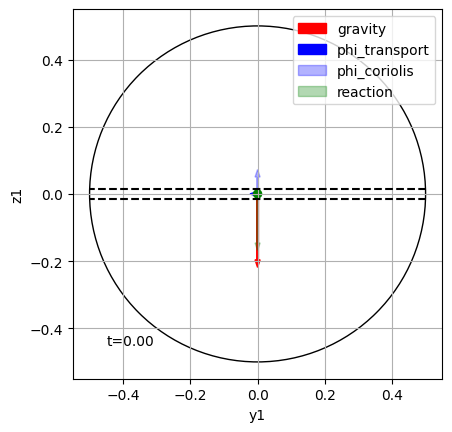

In [83]:
from matplotlib.animation import FuncAnimation

# import patches
from matplotlib.patches import Circle, Rectangle

fig, ax = plt.subplots()
ax.set_xlim(-0.55, 0.55)
ax.set_ylim(-0.55, 0.55)
ax.set_aspect("equal")
ax.grid()

diskA = Circle((0, 0), r, color="black", fill=False)
ax.add_patch(diskA)

actors = {
    "M": Circle((0, 0), 0.012, color="g"),
    "tube1": plt.Line2D([0, 1], [0, 1], color="black", linestyle="--"),
    "tube2": plt.Line2D([0, 1], [0, 1], color="black", linestyle="--"),
    "mg": ax.arrow(0, 0, 0, 0, color="r", width=0.005, label="gravity"),
    "transport": ax.arrow(0, 0, 0, 0, color="b", width=0.005, label="phi_transport"),
    "coriolis": ax.arrow(
        0, 0, 0, 0, color="b", width=0.005, alpha=0.3, label="phi_coriolis"
    ),
    "reaction": ax.arrow(
        0, 0, 0, 0, color="g", width=0.005, alpha=0.3, label="reaction"
    ),
    "time": ax.text(-0.45, -0.45, "t=0"),
}
ax.add_patch(actors["M"])
ax.add_line(actors["tube1"])
ax.add_line(actors["tube2"])


def animate(i):
    if i % 10 == 0:
        print(i)

    trace = traces[i]
    trace.animate(actors)
    actors["time"].set_text(f"t={trace.t:.2f}")


plt.legend()
plt.xlabel("y1")
plt.ylabel("z1")
anim = FuncAnimation(fig, animate, frames=len(traces), interval=1)

anim.save("task2.gif")
